# Image Classification Using Keras NN
In this notebook, we build and train a NN model for image classification from the Oregan WildLife dataset. We examine different hyperparamters, and test how the optimization functions, loss functions, regularizations, and numbers of epochs affect our training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/IPython/Univ-AI/CA4-2

/content/drive/.shortcut-targets-by-id/11C6xneL1c9BzrtnS5HOcRU83dXJ641VJ/IPython/Univ-AI/CA4-2


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/test/bald_eagle/023396cb25b3c3b42b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 1 - Packages
First, we import all the python packages that we'll need during this assignment.

- [Numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python
- [Pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
- [Matplotlib](https://matplotlib.org/) is a comprehensive library for creating static, animated, and interactive visualizations in Python
- [Sklearn](https://scikit-learn.org/) is a machine learning library for Python
- [Tensorflow](https://opencv.org/) TensorFlow is an end-to-end open source platform for machine learning.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras.layers as tfl

import os
import random
import math
import time
import warnings

# Setting matplotlib plotting options
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline
warnings.simplefilter("ignore")

## 2 - Dataset

### 2.1 - Read The Dataset
We read the dataset in grayscale mode, and generate the `tf.Dataset` objects for the train, validation, and test sets. This is done in the following cell. Note that we use a batch_size of 32 for it to be conformant across our later call to `model.fit` and our loading of the datasets.

In [4]:
MAX_BATCH_SIZE = 100000
train_dataset_dir = 'dataset/train' 
test_dataset_dir = 'dataset/test/' 

train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
# test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print('Train set details: ')
train_ds = train_data_generator.flow_from_directory(
  train_dataset_dir,
  subset='training',
  color_mode='grayscale',
  seed=1,
  class_mode='categorical',
  target_size=(64,64),
  batch_size=MAX_BATCH_SIZE)

print('\nValidation set details: ')
val_ds = train_data_generator.flow_from_directory(
  train_dataset_dir,
  subset='validation',
  color_mode='grayscale',
  seed=1,
  class_mode='categorical',
  target_size=(64,64),
  batch_size=MAX_BATCH_SIZE)

print('\nTest set details: ')
test_ds = train_data_generator.flow_from_directory(
  test_dataset_dir,
  color_mode='grayscale',
  batch_size=MAX_BATCH_SIZE,
  class_mode='categorical',
  target_size=(64,64),
)

Train set details: 
Found 1557 images belonging to 4 classes.

Validation set details: 
Found 388 images belonging to 4 classes.

Test set details: 
Found 833 images belonging to 4 classes.


<font color='green'>We've successfuly loaded our dataset into the corresponding train, validation, and test sets. We have 4 classes in each of the 3 generated sets as shown above.</font>

## 3 - Preprocessing

### 3.1 - Visualization
First, we start by showing the distribution of the datasets, and by visualizing random images of each of the classes in the train set. This would ultimately help validate the reading process, as well as to give an insightful look into the dataset.

First, we calculate the number of instatnces out of each of the classes in the available sets to plot a bar chart of the number of examples per class in each different set:

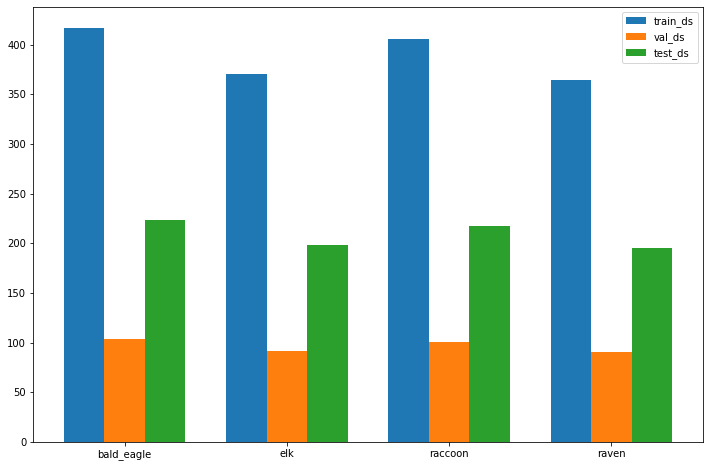

In [5]:
bar_width = 0.25
br = np.arange(len(train_ds.class_indices.keys()), dtype=np.float32)

plt.figure(figsize=(12,8))
for ds in [train_ds, val_ds, test_ds]:
  classes_dict = dict(zip(train_ds.class_indices.values(), train_ds.class_indices.keys()))
  classes = dict(zip(classes_dict.values(), np.zeros(len(ds.classes), dtype=np.int32)))

  for i in range(len(ds)):
    labels_counts = np.unique(ds[i][1], axis=0, return_counts=True)
    for i in range(labels_counts[0].shape[0]):
      classes[classes_dict[np.argmax(labels_counts[0][i])]] += labels_counts[1][i]
    
  plt.bar(br, classes.values(), width = bar_width)
  br += bar_width

plt.xticks([r + bar_width for r in range(len(train_ds.class_indices.keys()))],train_ds.class_indices.keys())
plt.legend(['train_ds', 'val_ds', 'test_ds'])
plt.show()

### 3.2 - Onehot Encoding
The labels are also onehot encoded as we used the `ImageDataGenerator` class for dataset generation. Having labels onehot encoded ensures that the labels (outputs of the neural net) are also normalized as the inputs are, and that we can interpret the neural net outputs as probabilities of each class per input.

### 3.3 - Normaliation
As we used the `ImageDataGenerator` from Tensorflow, the images in the generated datasets are already normalized to have pixel values ranging between 0 and 1.

### 3.4 - Numpy Array Generation For Training
Here, we generate numpy arrays for the future training of the models. This would ensure flexibility in our implementations for several functionalities, such as f1-score calculation in the future cells.

In [6]:
train_arr = iter(train_ds).next()
X_train = train_arr[0]
Y_train = train_arr[1]

val_arr = iter(val_ds).next()
X_val = val_arr[0]
Y_val = val_arr[1]

test_arr = iter(test_ds).next()
X_test = test_arr[0]
Y_test = test_arr[1]

print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'\nX_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'\nX_test shape: {X_test.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (1557, 64, 64, 1)
Y_train shape: (1557, 4)

X_val shape: (388, 64, 64, 1)
Y_val shape: (388, 4)

X_test shape: (833, 64, 64, 1)
X_test shape: (833, 64, 64, 1)


### 3.5 - Images Visualization
We next show a number of images corresponding to each of the different classes in the train set. This is done as follows:

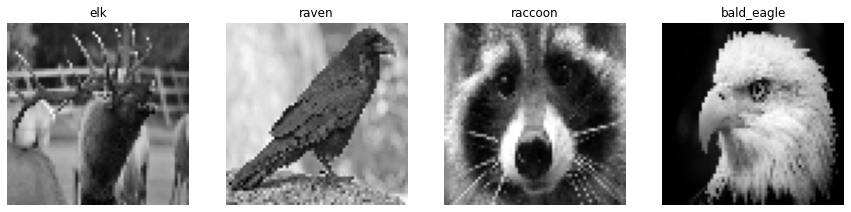

In [20]:
plt.figure(figsize=(15,60))

classes_dict = dict(zip(train_ds.class_indices.values(), train_ds.class_indices.keys()))
classes_covered = []

classes = Y_train.argmax(axis=1)

for i in range(len(X_train)):
  if classes[i] not in classes_covered:
    ax = plt.subplot(1, 4, len(classes_covered)+1)
    plt.imshow(X_train[i][..., 0], cmap='gray')
    plt.title(classes_dict[classes[i]])
    plt.axis("off")
    classes_covered.append(classes[i])

## 4 - Neural Net

We define our Keras NN model using the Keras functional API. This way, we ensure the flexibility of our model for future developments. 

In the rest of this notebook, we'll also continue to evolve this model, and will further tune hyperparameters.

In [ ]:
def model_df(input_shape, n_hiddenlayers=2, n_a=100, n_o=4, activation='relu'):
  X_input = tfl.Input(input_shape)
  X = tfl.Flatten()(X_input)
  for i in range(n_hiddenlayers):
    X = tfl.Dense(n_a, activation=activation)(X)

  X = tfl.Dense(n_o, activation='softmax')(X)
  return tf.keras.Model(inputs=X_input, outputs=X)

### 4.1 - Initial Model

Now, we instantiate and train a Neural network with 3 hidden layers, each having 1000 units. This would serve as our starting model which will be further improved down the line.

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_17 (Flatten)        (None, 4096)              0         
                                                                 
 dense_55 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_56 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_57 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


The number of parameters shown in the above summary, comes from $n_a^{(l)}*n_a^{(l-1)}$ for each layer $l$. Note that when considering the number of activations (units) in the previous layer, the bias unit has to also be taken into account, adding up 1 to the number of units in the corresponding previous layer.

For example, for the first dense layer, the number of trainable params comes from $(4096+1)*1000=4097000$.

**Note**: The first two layers in the above summary have no trainable params. So, the #params is also shown as 0.

Next, we compile and fit the model with the provided hyperparams in the project set.

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=10)

Epoch 1/10
49/49 [==============================] - 1s 11ms/step - loss: 1.3694 - accuracy: 0.3083 - val_loss: 1.2587 - val_accuracy: 0.3531
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 1.2273 - accuracy: 0.4509 - val_loss: 1.2687 - val_accuracy: 0.4175
Epoch 3/10
49/49 [==============================] - 0s 8ms/step - loss: 1.1613 - accuracy: 0.4798 - val_loss: 1.1822 - val_accuracy: 0.4665
Epoch 4/10
49/49 [==============================] - 0s 8ms/step - loss: 1.1159 - accuracy: 0.5311 - val_loss: 1.1071 - val_accuracy: 0.5155
Epoch 5/10
49/49 [==============================] - 0s 7ms/step - loss: 1.0679 - accuracy: 0.5517 - val_loss: 1.0754 - val_accuracy: 0.5541
Epoch 6/10
49/49 [==============================] - 0s 7ms/step - loss: 1.0393 - accuracy: 0.5761 - val_loss: 1.1742 - val_accuracy: 0.4330
Epoch 7/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0322 - accuracy: 0.5543 - val_loss: 1.0968 - val_accuracy: 0.4716
Epoch 8/10
49/49 [=

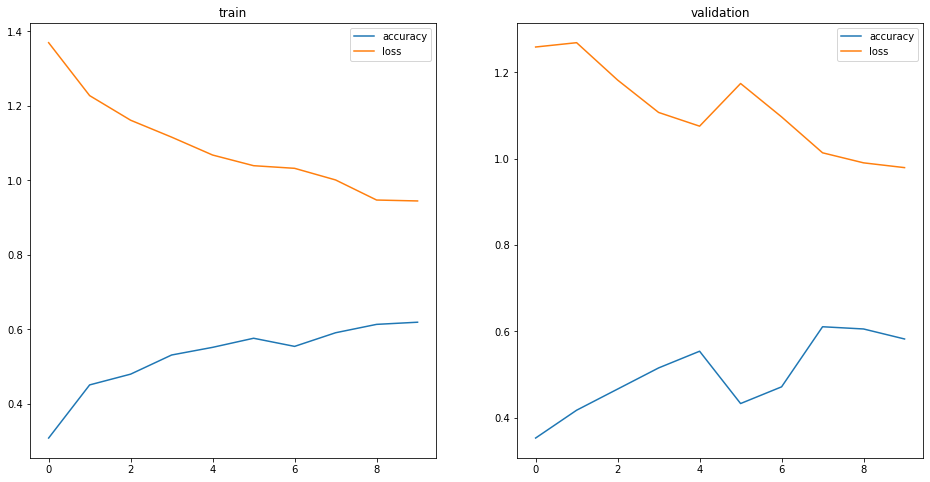

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.89      0.38      0.53       417
           1       0.75      0.68      0.71       370
           2       0.58      0.89      0.70       406
           3       0.66      0.76      0.70       364

    accuracy                           0.67      1557
   macro avg       0.72      0.67      0.66      1557
weighted avg       0.72      0.67      0.66      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.78      0.24      0.37       104
           1       0.62      0.51      0.56        92
           2       0.50      0.85      0.63       101
           3       0.62      0.75      0.68        91

    accuracy                           0.58       388
   macro avg       0.63      0.59      0.56       388
weighted avg       0.63      0.58      0.56       388



### 4.2 - Optimizers
Here, we examine the effectiveness of different optimization functions. We use optimizers with momentum and the Adam optimizer in this section.

#### 4.2.1 - Momentum
Momentum, as used in optimizing the training of neural networks, accumulates the past gradients using an exponential moving average to make future gradient changes less significant. Using momentum, the gradient descent algorithm steps much more robustly, and in a more straight way down the contours. This would ultimatly make training faster with good hyperparameters set for the momentum.

We now use momentum with the SGD implementation to speed up training. This's done in the following cells.

First, we use a momentum of 0.5. A model with such parameter is trained as follows:

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_25 (Flatten)        (None, 4096)              0         
                                                                 
 dense_79 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_80 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_81 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=10)

Epoch 1/10
49/49 [==============================] - 1s 13ms/step - loss: 1.3207 - accuracy: 0.3892 - val_loss: 1.2407 - val_accuracy: 0.4459
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 1.1666 - accuracy: 0.4875 - val_loss: 1.1555 - val_accuracy: 0.4974
Epoch 3/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0929 - accuracy: 0.5305 - val_loss: 1.1868 - val_accuracy: 0.4742
Epoch 4/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0441 - accuracy: 0.5511 - val_loss: 1.0610 - val_accuracy: 0.5541
Epoch 5/10
49/49 [==============================] - 0s 8ms/step - loss: 0.9727 - accuracy: 0.6044 - val_loss: 1.0695 - val_accuracy: 0.5284
Epoch 6/10
49/49 [==============================] - 0s 8ms/step - loss: 0.9228 - accuracy: 0.6358 - val_loss: 0.9823 - val_accuracy: 0.6005
Epoch 7/10
49/49 [==============================] - 0s 8ms/step - loss: 0.8864 - accuracy: 0.6455 - val_loss: 0.9442 - val_accuracy: 0.6753
Epoch 8/10
49/49 [=

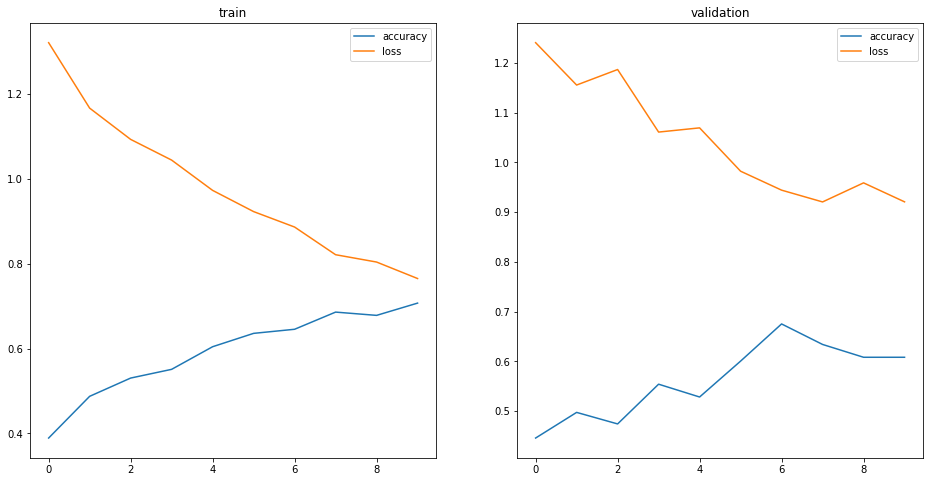

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       417
           1       0.68      0.91      0.78       370
           2       0.90      0.77      0.83       406
           3       0.57      0.91      0.70       364

    accuracy                           0.71      1557
   macro avg       0.77      0.72      0.69      1557
weighted avg       0.78      0.71      0.69      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.77      0.26      0.39       104
           1       0.59      0.78      0.67        92
           2       0.74      0.59      0.66       101
           3       0.52      0.85      0.64        91

    accuracy                           0.61       388
   macro avg       0.65      0.62      0.59       388
weighted avg       0.66      0.61      0.59       388



Next, we use a momentum with $\beta=0.9$:

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_24 (Flatten)        (None, 4096)              0         
                                                                 
 dense_76 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_77 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_78 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=10)

Epoch 1/10
49/49 [==============================] - 1s 12ms/step - loss: 1.3656 - accuracy: 0.3648 - val_loss: 1.2793 - val_accuracy: 0.3763
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 1.2077 - accuracy: 0.4297 - val_loss: 1.1069 - val_accuracy: 0.5412
Epoch 3/10
49/49 [==============================] - 0s 8ms/step - loss: 1.1437 - accuracy: 0.4817 - val_loss: 1.1388 - val_accuracy: 0.4768
Epoch 4/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0982 - accuracy: 0.5074 - val_loss: 1.1182 - val_accuracy: 0.4639
Epoch 5/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0749 - accuracy: 0.5311 - val_loss: 1.1652 - val_accuracy: 0.4794
Epoch 6/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0089 - accuracy: 0.5697 - val_loss: 1.0082 - val_accuracy: 0.5438
Epoch 7/10
49/49 [==============================] - 0s 8ms/step - loss: 0.9353 - accuracy: 0.6050 - val_loss: 1.2142 - val_accuracy: 0.5077
Epoch 8/10
49/49 [=

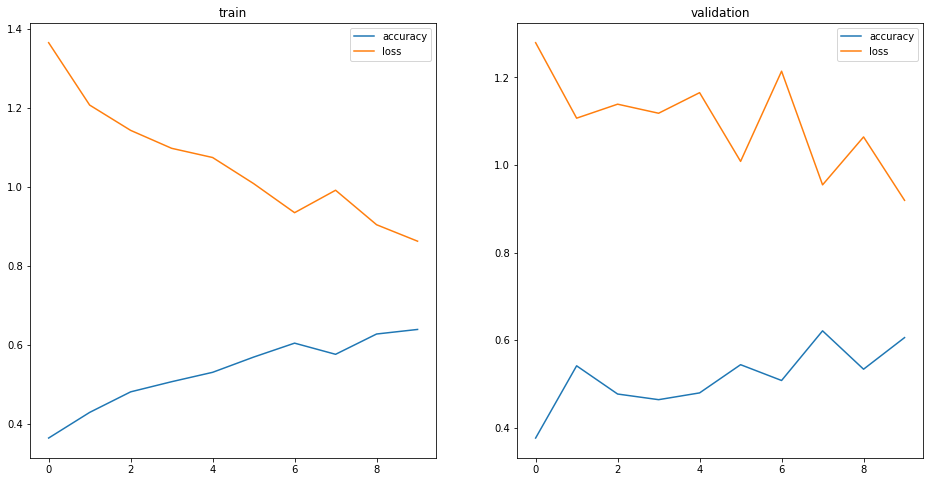

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       417
           1       0.53      0.95      0.68       370
           2       0.91      0.64      0.75       406
           3       0.77      0.70      0.73       364

    accuracy                           0.69      1557
   macro avg       0.75      0.70      0.70      1557
weighted avg       0.75      0.69      0.69      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.63      0.42      0.51       104
           1       0.48      0.93      0.64        92
           2       0.84      0.50      0.63       101
           3       0.68      0.59      0.64        91

    accuracy                           0.61       388
   macro avg       0.66      0.61      0.60       388
weighted avg       0.66      0.61      0.60       388



<font color='blue'>With a momentum of 0.9, we almost always see less fluctuations in the convergence of the loss, and with lower values of momentum, we most of the time get more fluctuations and less robustness in the training process. This, makes the training most of time faster with a momentum of 0.9.
</font>

<font color='blue'>
Also, with very large values of momentum like 0.99, we get a loss that is not flexible, and does not get the latest gradient effects, thus, slowing down the learning process.</font>



#### 4.2.2 - Adam
Here, we use the Adam optimizer to get better convergence speen during training. This is done with the original parameters and a learning rate of 0.001, and a model with the Adam optimizer is trained below:

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_30 (Flatten)        (None, 4096)              0         
                                                                 
 dense_94 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_95 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_96 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=10)

Epoch 1/10
49/49 [==============================] - 1s 12ms/step - loss: 2.0906 - accuracy: 0.3231 - val_loss: 1.2756 - val_accuracy: 0.4588
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 1.2102 - accuracy: 0.4277 - val_loss: 1.1199 - val_accuracy: 0.4923
Epoch 3/10
49/49 [==============================] - 0s 9ms/step - loss: 1.1550 - accuracy: 0.4695 - val_loss: 1.0852 - val_accuracy: 0.4923
Epoch 4/10
49/49 [==============================] - 0s 9ms/step - loss: 1.1180 - accuracy: 0.4849 - val_loss: 1.1301 - val_accuracy: 0.5155
Epoch 5/10
49/49 [==============================] - 0s 8ms/step - loss: 1.0465 - accuracy: 0.5260 - val_loss: 1.0176 - val_accuracy: 0.5567
Epoch 6/10
49/49 [==============================] - 0s 9ms/step - loss: 0.9962 - accuracy: 0.5633 - val_loss: 1.1247 - val_accuracy: 0.4820
Epoch 7/10
49/49 [==============================] - 0s 9ms/step - loss: 0.9846 - accuracy: 0.5838 - val_loss: 1.0510 - val_accuracy: 0.5515
Epoch 8/10
49/49 [=

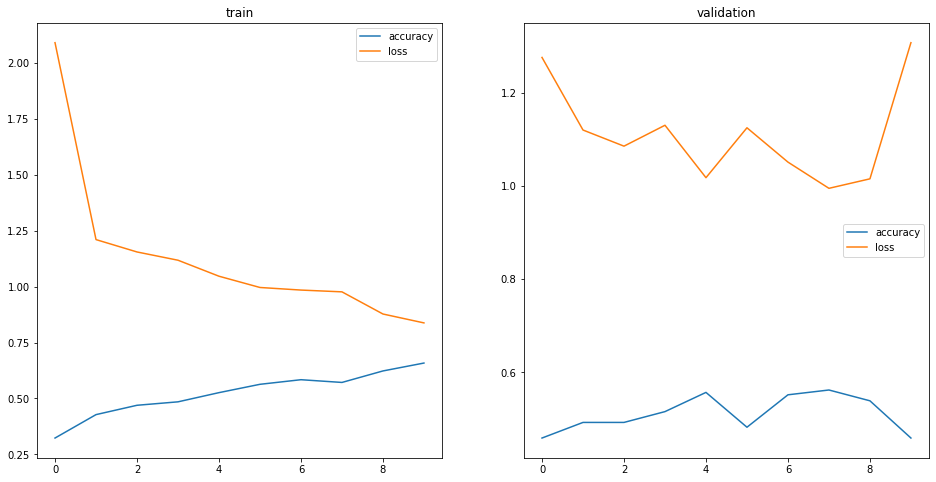

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.46      0.89      0.60       417
           1       0.73      0.66      0.69       370
           2       0.98      0.39      0.56       406
           3       0.77      0.52      0.62       364

    accuracy                           0.62      1557
   macro avg       0.74      0.62      0.62      1557
weighted avg       0.73      0.62      0.62      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.42      0.83      0.56       104
           1       0.54      0.50      0.52        92
           2       0.91      0.30      0.45       101
           3       0.68      0.49      0.57        91

    accuracy                           0.53       388
   macro avg       0.64      0.53      0.52       388
weighted avg       0.64      0.53      0.52       388



<font color='blue'>With the Adam optimizer, the convergence was faster than with a momentum of 0.9.We'll continue to use this optimizer for the rest of this notebook.</font>

### 4.3 - Epochs
We examine the effectiveness of additional epochs in the training procedure. The general rule of thumb is that unless the model overfits, the validation accuracy increases with additional number of epochs.

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_31 (Flatten)        (None, 4096)              0         
                                                                 
 dense_97 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_98 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_99 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20)

Epoch 1/20
49/49 [==============================] - 1s 12ms/step - loss: 1.9630 - accuracy: 0.3340 - val_loss: 1.3912 - val_accuracy: 0.3711
Epoch 2/20
49/49 [==============================] - 0s 9ms/step - loss: 1.2334 - accuracy: 0.4155 - val_loss: 1.1980 - val_accuracy: 0.4356
Epoch 3/20
49/49 [==============================] - 0s 9ms/step - loss: 1.1893 - accuracy: 0.4515 - val_loss: 1.2460 - val_accuracy: 0.3737
Epoch 4/20
49/49 [==============================] - 0s 9ms/step - loss: 1.1601 - accuracy: 0.4502 - val_loss: 1.2047 - val_accuracy: 0.4046
Epoch 5/20
49/49 [==============================] - 0s 9ms/step - loss: 1.1442 - accuracy: 0.4522 - val_loss: 1.0994 - val_accuracy: 0.5232
Epoch 6/20
49/49 [==============================] - 0s 8ms/step - loss: 1.0558 - accuracy: 0.5324 - val_loss: 1.1500 - val_accuracy: 0.4923
Epoch 7/20
49/49 [==============================] - 0s 9ms/step - loss: 1.0266 - accuracy: 0.5318 - val_loss: 0.9881 - val_accuracy: 0.5825
Epoch 8/20
49/49 [=

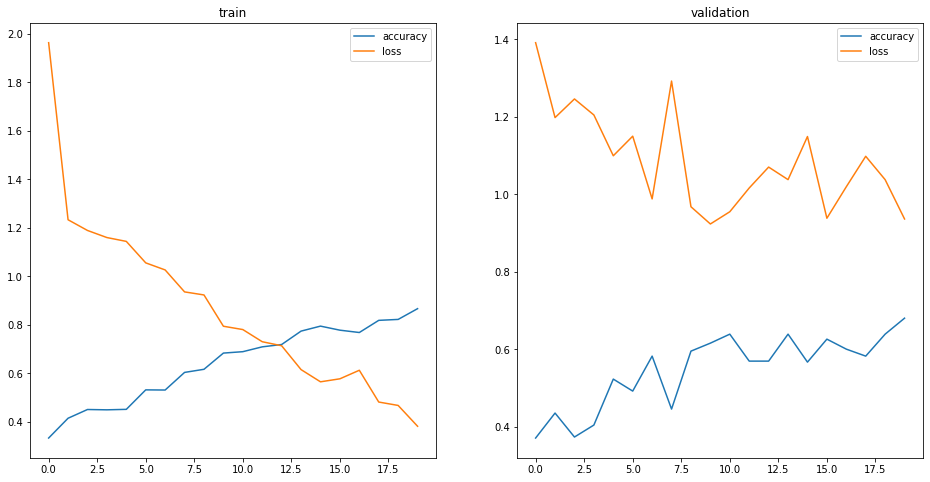

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       417
           1       0.85      0.97      0.91       370
           2       0.95      0.90      0.92       406
           3       0.96      0.71      0.82       364

    accuracy                           0.88      1557
   macro avg       0.89      0.88      0.88      1557
weighted avg       0.89      0.88      0.88      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.60      0.72      0.65       104
           1       0.64      0.82      0.71        92
           2       0.77      0.67      0.72       101
           3       0.82      0.51      0.63        91

    accuracy                           0.68       388
   macro avg       0.71      0.68      0.68       388
weighted avg       0.70      0.68      0.68       388



<font color='green'>With 20 epochs, we got much better results on both the training and validation sets.</font>

**Note**: We most of the time do train neural nets for several epochs. This usually gives better performance to the training of the model, as the model sees the data for several times. This's not always and in all applications required though.

Now, we train a model until it overfits. This would be obvious by looking at the divergence of the validation loss on its plot versus time.

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()vergence of the validavergence of the validation loss on its plot versus time.tion loss on itvergence of the validation loss on its plot versus time.svergence of the validation loss on its plot versus time. plot versus time.

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_32 (Flatten)        (None, 4096)              0         
                                                                 
 dense_100 (Dense)           (None, 1000)              4097000   
                                                                 
 dense_101 (Dense)           (None, 1000)              1001000   
                                                                 
 dense_102 (Dense)           (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=60)

Epoch 1/60
49/49 [==============================] - 1s 12ms/step - loss: 2.0598 - accuracy: 0.3198 - val_loss: 1.2327 - val_accuracy: 0.4691
Epoch 2/60
49/49 [==============================] - 0s 8ms/step - loss: 1.2641 - accuracy: 0.4059 - val_loss: 1.2177 - val_accuracy: 0.4381
Epoch 3/60
49/49 [==============================] - 0s 9ms/step - loss: 1.1596 - accuracy: 0.4708 - val_loss: 1.1283 - val_accuracy: 0.5155
Epoch 4/60
49/49 [==============================] - 0s 8ms/step - loss: 1.1401 - accuracy: 0.4817 - val_loss: 1.1434 - val_accuracy: 0.5103
Epoch 5/60
49/49 [==============================] - 0s 9ms/step - loss: 1.0911 - accuracy: 0.4997 - val_loss: 1.0421 - val_accuracy: 0.5747
Epoch 6/60
49/49 [==============================] - 0s 8ms/step - loss: 1.0584 - accuracy: 0.5382 - val_loss: 1.0841 - val_accuracy: 0.4691
Epoch 7/60
49/49 [==============================] - 0s 8ms/step - loss: 0.9696 - accuracy: 0.5851 - val_loss: 0.9867 - val_accuracy: 0.6005
Epoch 8/60
49/49 [=

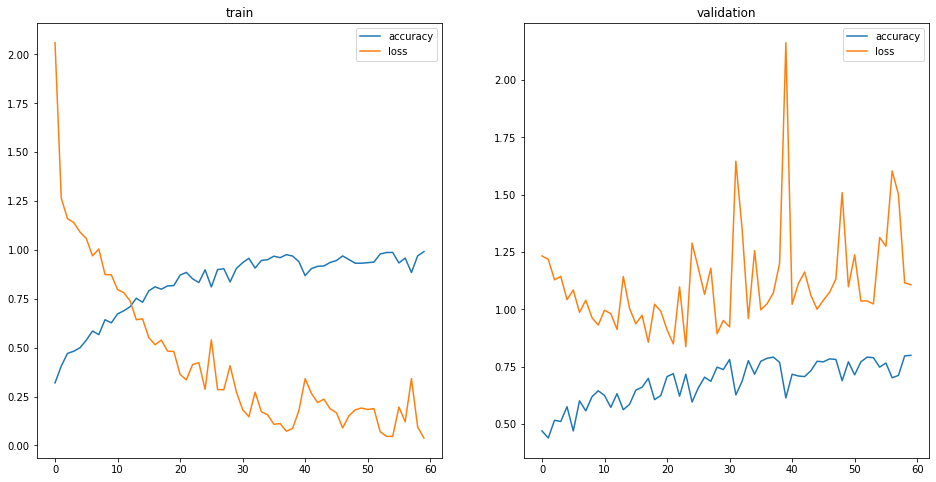

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       406
           3       1.00      0.99      1.00       364

    accuracy                           1.00      1557
   macro avg       1.00      1.00      1.00      1557
weighted avg       1.00      1.00      1.00      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       104
           1       0.78      0.79      0.79        92
           2       0.82      0.84      0.83       101
           3       0.78      0.84      0.80        91

    accuracy                           0.80       388
   macro avg       0.80      0.80      0.80       388
weighted avg       0.80      0.80      0.80       388



<font color='blue'>The model is clearly overfitting since the range of 12 to 23 epochs, with the most probable case being epoch number 23 for it. We obviously see the val_loss starting to go up and the val_accuracy starting to drop or at least plateau from that point.</font>

Next, we use early stopping to make stop the training before overfitting occurs. This is done by using the Keras `Earlystoppig` callback for the training process:

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_36 (Flatten)        (None, 4096)              0         
                                                                 
 dense_112 (Dense)           (None, 1000)              4097000   
                                                                 
 dense_113 (Dense)           (None, 1000)              1001000   
                                                                 
 dense_114 (Dense)           (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=60, callbacks=[early])

Epoch 1/60
49/49 [==============================] - 1s 12ms/step - loss: 2.2007 - accuracy: 0.3282 - val_loss: 1.2138 - val_accuracy: 0.4381
Epoch 2/60
49/49 [==============================] - 0s 9ms/step - loss: 1.2488 - accuracy: 0.4027 - val_loss: 1.1877 - val_accuracy: 0.4433
Epoch 3/60
49/49 [==============================] - 0s 9ms/step - loss: 1.1841 - accuracy: 0.4470 - val_loss: 1.1275 - val_accuracy: 0.4716
Epoch 4/60
49/49 [==============================] - 0s 9ms/step - loss: 1.1211 - accuracy: 0.4740 - val_loss: 1.0875 - val_accuracy: 0.5412
Epoch 5/60
49/49 [==============================] - 0s 9ms/step - loss: 1.0858 - accuracy: 0.5022 - val_loss: 1.0891 - val_accuracy: 0.4845
Epoch 6/60
49/49 [==============================] - 0s 8ms/step - loss: 1.0842 - accuracy: 0.5035 - val_loss: 1.1612 - val_accuracy: 0.4820
Epoch 7/60
49/49 [==============================] - 0s 8ms/step - loss: 1.0739 - accuracy: 0.5061 - val_loss: 1.1620 - val_accuracy: 0.4510
Epoch 8/60
49/49 [=

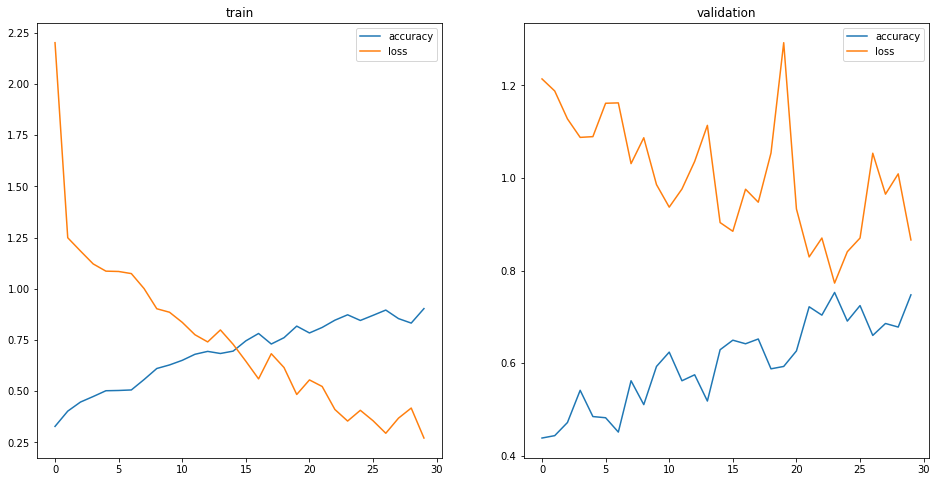

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       417
           1       0.98      0.96      0.97       370
           2       0.93      0.98      0.96       406
           3       0.90      0.90      0.90       364

    accuracy                           0.93      1557
   macro avg       0.93      0.93      0.93      1557
weighted avg       0.93      0.93      0.93      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       104
           1       0.81      0.76      0.79        92
           2       0.74      0.86      0.79       101
           3       0.72      0.75      0.73        91

    accuracy                           0.75       388
   macro avg       0.75      0.75      0.75       388
weighted avg       0.75      0.75      0.75       388



<font color='blue'>We set a patience of 6 for the val_loss to to drop, in which case, we stop the training.</font>



<font color='green'>We got much better performance with early stopping turned on.</font>



Increasing the number of epochs, is effective on the performance of the model unless it overfits. From there, training for further epochs makes the model overfit the train set, and therefore the performance on the validation and test sets drops in the optimal case.

To battle overfitting, there are a number of practical ways in deep learning. Such ways include regularization methods such as L2 regularization and dropout, as well as training on bigger sets of data.

### 4.4 - Loss Function
The loss function has a great effect on the training performance. As an example, usage of regression loss functions like MSE and MAE for classification problems is strongly discouraged. We examine this property in the following cells:

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_39 (Flatten)        (None, 4096)              0         
                                                                 
 dense_121 (Dense)           (None, 1000)              4097000   
                                                                 
 dense_122 (Dense)           (None, 1000)              1001000   
                                                                 
 dense_123 (Dense)           (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=60, callbacks=[early])

Epoch 1/60
49/49 [==============================] - 1s 11ms/step - loss: 0.3634 - accuracy: 0.2659 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 2/60
49/49 [==============================] - 0s 8ms/step - loss: 0.3696 - accuracy: 0.2608 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 3/60
49/49 [==============================] - 0s 9ms/step - loss: 0.3696 - accuracy: 0.2608 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 4/60
49/49 [==============================] - 0s 8ms/step - loss: 0.3696 - accuracy: 0.2608 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 5/60
49/49 [==============================] - 0s 8ms/step - loss: 0.3696 - accuracy: 0.2608 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 6/60
49/49 [==============================] - 0s 9ms/step - loss: 0.3696 - accuracy: 0.2608 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 7/60
49/49 [==============================] - 0s 8ms/step - loss: 0.3696 - accuracy: 0.2608 - val_loss: 0.3698 - val_accuracy: 0.2603
Epoch 8/60
49/49 [=

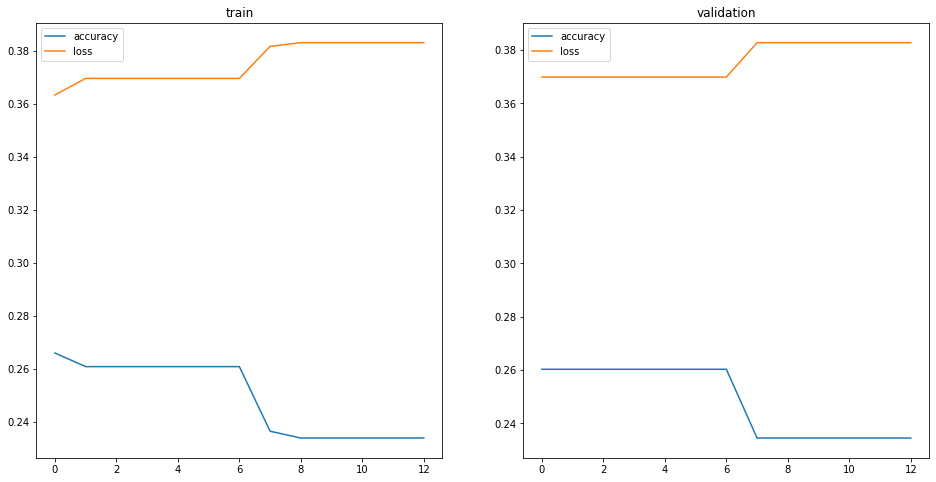

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])vergence of the validation loss on its plot versus time.
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       417
           1       0.00      0.00      0.00       370
           2       0.00      0.00      0.00       406
           3       0.23      1.00      0.38       364

    accuracy                           0.23      1557
   macro avg       0.06      0.25      0.09      1557
weighted avg       0.05      0.23      0.09      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.00      0.00      0.00        92
           2       0.00      0.00      0.00       101
           3       0.23      1.00      0.38        91

    accuracy                           0.23       388
   macro avg       0.06      0.25      0.09       388
weighted avg       0.06      0.23      0.09       388



<font color='blue'>We see the loss and accuracy plots almost plateauing from the beginning of the training, and the loss also not minimizing.‌ This could essentially be linked to the fact that the MSE loss function, is not convex for multiclass classification. As a result, the weights do not converge to the optimal point during training.

Loss functions such as MSE and MAE are used with regression problems, where the goal is to predict some contintious value along an axis. These functions are not suitable for classification problems.</font>



### 4.5 - Regularization
In this section, we examine how regulaization can affect the learning process of the model>

### 4.5.1 - L2 Regularization
L2 regularization penalizes the weights, not to let them become too much big. It actually forces some of the weights out of the forward/backward propagation process at each step, and esentially makes the model not solely rely on a small number of weights. This, ultimately lowers the variace of the model, and increases generalization.

In [36]:
def model_df(input_shape, n_hiddenlayers=2, n_a=100, n_o=4, activation='relu', L2_reg=0, use_dropout=False, dropout_rate=0.1):
  X_input = tfl.Input(input_shape)
  X = tfl.Flatten()(X_input)
  for i in range(n_hiddenlayers):
    X = tfl.Dense(n_a, activation=activation, kernel_regularizer=tf.keras.regularizers.L2(L2_reg), bias_regularizer=tf.keras.regularizers.L2(L2_reg))(X)
    if use_dropout:
      X = tfl.Dropout(dropout_rate)(X)

  X = tfl.Dense(n_o, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(L2_reg), bias_regularizer=tf.keras.regularizers.L2(L2_reg))(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu', L2_reg=0.0001)
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_40 (Flatten)        (None, 4096)              0         
                                                                 
 dense_124 (Dense)           (None, 1000)              4097000   
                                                                 
 dense_125 (Dense)           (None, 1000)              1001000   
                                                                 
 dense_126 (Dense)           (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=60, callbacks=[early])

Epoch 1/60
49/49 [==============================] - 1s 16ms/step - loss: 2.4072 - accuracy: 0.3134 - val_loss: 1.5368 - val_accuracy: 0.3814
Epoch 2/60
49/49 [==============================] - 0s 10ms/step - loss: 1.4278 - accuracy: 0.4059 - val_loss: 1.3435 - val_accuracy: 0.4588
Epoch 3/60
49/49 [==============================] - 0s 10ms/step - loss: 1.3182 - accuracy: 0.4727 - val_loss: 1.2679 - val_accuracy: 0.4820
Epoch 4/60
49/49 [==============================] - 0s 9ms/step - loss: 1.2940 - accuracy: 0.4894 - val_loss: 1.3331 - val_accuracy: 0.4562
Epoch 5/60
49/49 [==============================] - 0s 10ms/step - loss: 1.2497 - accuracy: 0.5016 - val_loss: 1.2292 - val_accuracy: 0.5284
Epoch 6/60
49/49 [==============================] - 0s 10ms/step - loss: 1.1961 - accuracy: 0.5453 - val_loss: 1.2168 - val_accuracy: 0.5180
Epoch 7/60
49/49 [==============================] - 0s 10ms/step - loss: 1.1182 - accuracy: 0.5877 - val_loss: 1.2779 - val_accuracy: 0.5103
Epoch 8/60
49/

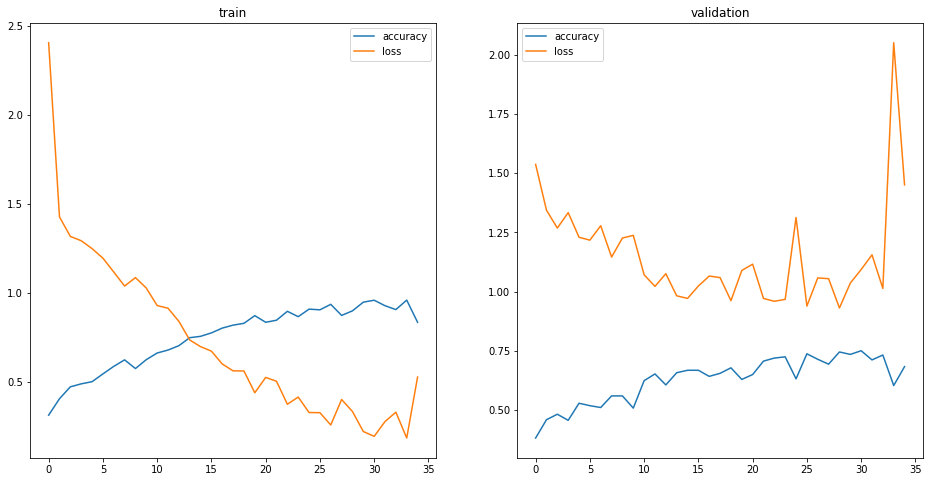

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])vergence of the validation loss on its plot versus time.
plt.title('validation')
plt.show()

In [ ]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       417
           1       0.89      1.00      0.94       370
           2       0.97      0.97      0.97       406
           3       1.00      0.42      0.59       364

    accuracy                           0.85      1557
   macro avg       0.89      0.84      0.83      1557
weighted avg       0.88      0.85      0.83      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.56      0.78      0.65       104
           1       0.68      0.89      0.77        92
           2       0.79      0.73      0.76       101
           3       0.97      0.31      0.47        91

    accuracy                           0.68       388
   macro avg       0.75      0.68      0.66       388
weighted avg       0.74      0.68      0.66       388



<font color='blue'>With the L2 regularization applied, we're avoiding overfitting for more training epochs as shown in the above plot. This means that we're generalizing better, and having a lower variance.</font>



### 4.5.2 - Dropout Regularization
Now, we apply dropout to the model. Dropout makes the model once again not rely solely on certain neurons for prediction, thus increasing robustness and generalization, and decreasing the model's variance.

In [37]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu', use_dropout=True, dropout_rate=0.1)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 1000)              4097000   
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 4)                 4004

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [39]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=60, callbacks=[early])

Epoch 1/60
49/49 [==============================] - 1s 14ms/step - loss: 2.2276 - accuracy: 0.3044 - val_loss: 1.2807 - val_accuracy: 0.3763
Epoch 2/60
49/49 [==============================] - 0s 9ms/step - loss: 1.2450 - accuracy: 0.3918 - val_loss: 1.1526 - val_accuracy: 0.4665
Epoch 3/60
49/49 [==============================] - 0s 10ms/step - loss: 1.1930 - accuracy: 0.4534 - val_loss: 1.1817 - val_accuracy: 0.4175
Epoch 4/60
49/49 [==============================] - 0s 9ms/step - loss: 1.1598 - accuracy: 0.4502 - val_loss: 1.1530 - val_accuracy: 0.4562
Epoch 5/60
49/49 [==============================] - 0s 9ms/step - loss: 1.1400 - accuracy: 0.4631 - val_loss: 1.1169 - val_accuracy: 0.4974
Epoch 6/60
49/49 [==============================] - 0s 9ms/step - loss: 1.0937 - accuracy: 0.4875 - val_loss: 1.0518 - val_accuracy: 0.5670
Epoch 7/60
49/49 [==============================] - 0s 9ms/step - loss: 1.0859 - accuracy: 0.5106 - val_loss: 1.0523 - val_accuracy: 0.5722
Epoch 8/60
49/49 [

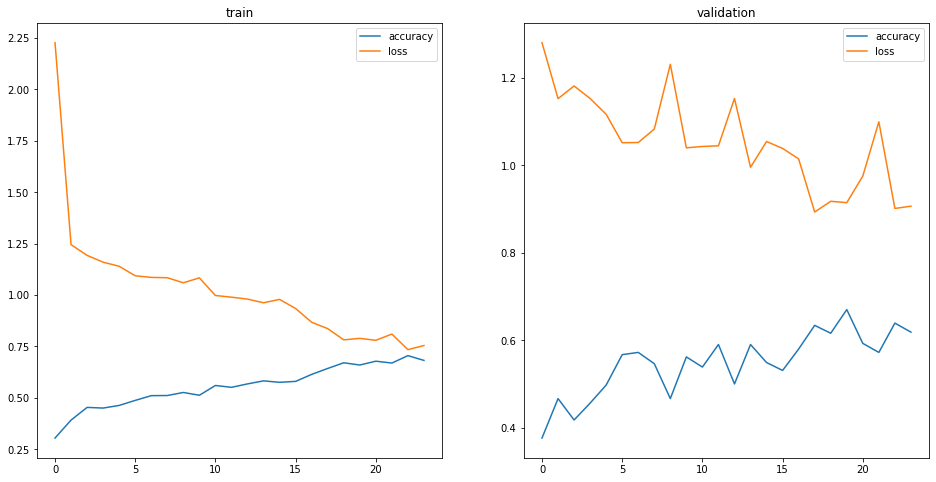

In [42]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [43]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       417
           1       0.77      0.91      0.83       370
           2       0.89      0.87      0.88       406
           3       0.89      0.49      0.63       364

    accuracy                           0.77      1557
   macro avg       0.80      0.77      0.76      1557
weighted avg       0.79      0.77      0.77      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.51      0.68      0.58       104
           1       0.66      0.73      0.69        92
           2       0.66      0.66      0.66       101
           3       0.76      0.38      0.51        91

    accuracy                           0.62       388
   macro avg       0.65      0.61      0.61       388
weighted avg       0.64      0.62      0.61       388



<font color='blue'>We're again getting a nice regularization effect which has reduced variance, and has made model's generalization better on the validation set. </font>



## 5 - Testing
Finally, we test our model on the test set and report different accuracy scores on it. We use our simple model with 20 epochs, in which case we got the best accuracy on the validation set.

In [52]:
model = model_df((64, 64,1), n_hiddenlayers=2, n_a=1000, n_o=4, activation='relu')
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_19 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_20 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 5,102,004
Trainable params: 5,102,004
Non-trainable params: 0
_________________________________________________________________


In [53]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [54]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20)

Epoch 1/20
49/49 [==============================] - 2s 15ms/step - loss: 2.2239 - accuracy: 0.3121 - val_loss: 1.3096 - val_accuracy: 0.4124
Epoch 2/20
49/49 [==============================] - 0s 10ms/step - loss: 1.2117 - accuracy: 0.4393 - val_loss: 1.1208 - val_accuracy: 0.4820
Epoch 3/20
49/49 [==============================] - 0s 9ms/step - loss: 1.1284 - accuracy: 0.4695 - val_loss: 1.1258 - val_accuracy: 0.4923
Epoch 4/20
49/49 [==============================] - 0s 9ms/step - loss: 1.1362 - accuracy: 0.4676 - val_loss: 1.1253 - val_accuracy: 0.5077
Epoch 5/20
49/49 [==============================] - 0s 9ms/step - loss: 1.0442 - accuracy: 0.5440 - val_loss: 1.0660 - val_accuracy: 0.5077
Epoch 6/20
49/49 [==============================] - 0s 9ms/step - loss: 1.0074 - accuracy: 0.5511 - val_loss: 1.1206 - val_accuracy: 0.4639
Epoch 7/20
49/49 [==============================] - 0s 9ms/step - loss: 0.9156 - accuracy: 0.6166 - val_loss: 1.0623 - val_accuracy: 0.5567
Epoch 8/20
49/49 [

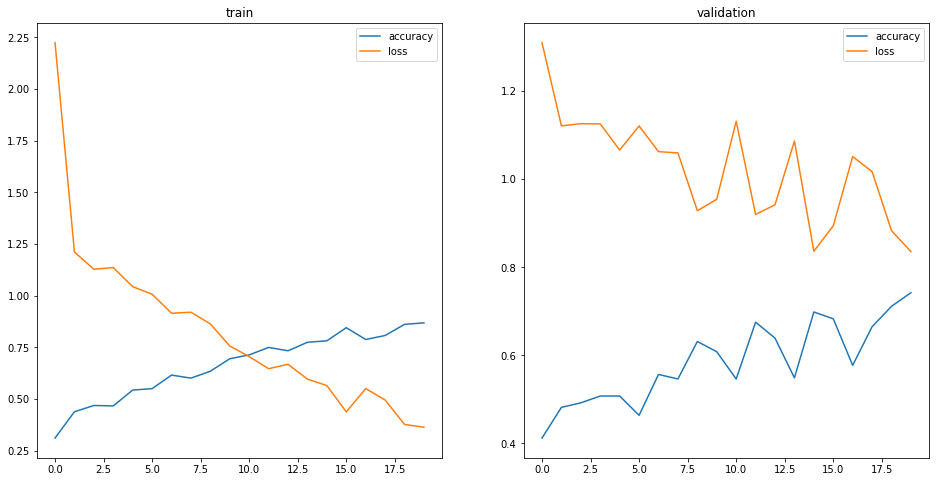

In [55]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.title('train')

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['accuracy', 'loss'])
plt.title('validation')
plt.show()

In [57]:
train_pred = model.predict(X_train).argmax(axis=1)
val_pred = model.predict(X_val).argmax(axis=1)
test_pred = model.predict(X_test).argmax(axis=1)

print('Train classification report:')
print(classification_report(Y_train.argmax(axis=1), train_pred))

print('\nValidation classification report:')
print(classification_report(Y_val.argmax(axis=1), val_pred))

print('\nTest classification report:')
print(classification_report(Y_test.argmax(axis=1), test_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       417
           1       0.97      0.97      0.97       370
           2       0.99      0.91      0.95       406
           3       0.88      0.92      0.90       364

    accuracy                           0.93      1557
   macro avg       0.93      0.93      0.93      1557
weighted avg       0.93      0.93      0.93      1557


Validation classification report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       104
           1       0.80      0.78      0.79        92
           2       0.85      0.68      0.76       101
           3       0.68      0.80      0.74        91

    accuracy                           0.74       388
   macro avg       0.75      0.74      0.74       388
weighted avg       0.75      0.74      0.74       388


Test classification report:
              precision    recall  f1

<font color='green'>We're getting great results with an accuracy of over %73, and a macro f1-score of nearly 0.74 on the test set.</font>



We now show 10 cases for which we've predicted correctly, and 10 of them for which we've predicted wrong labels in the test set.

Some Correct predictions: 


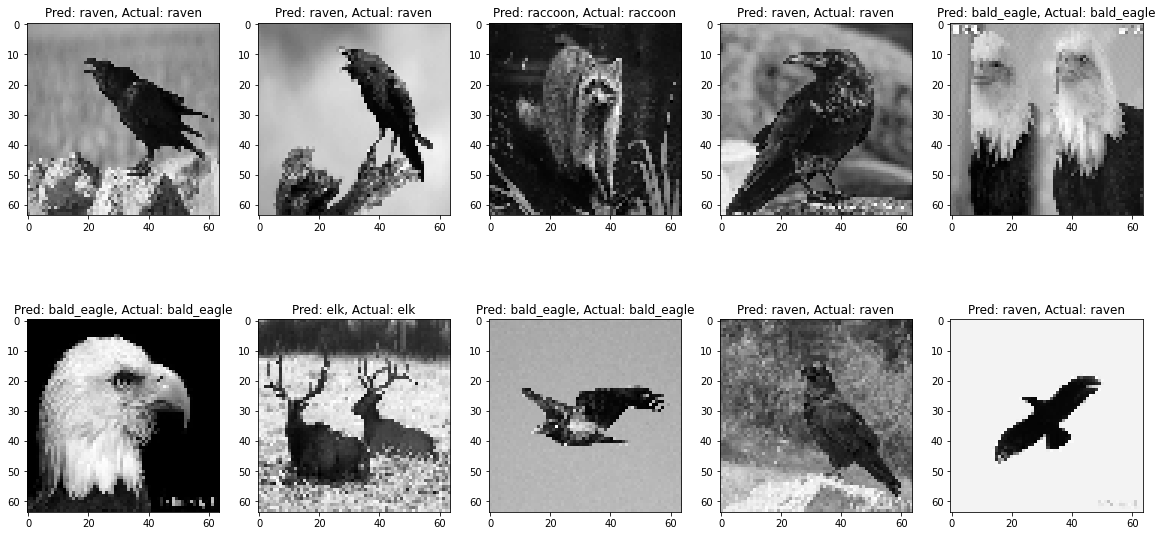

In [74]:
test_cond = Y_test.argmax(axis=1) == test_pred
classes_dict = dict(zip(train_ds.class_indices.values(), train_ds.class_indices.keys()))
print('Some Correct predictions: ')
count = 0
plt.figure(figsize=(20,10))
for i in range(len(test_cond)):
  if test_cond[i] == False:
    continue
  plt.subplot(2,5,count+1)
  plt.imshow(X_test[i][..., 0], cmap='gray')
  plt.title(f'Pred: {classes_dict[test_pred[i]]}, Actual: {classes_dict[Y_test.argmax(axis=1)[i]]}')
  count += 1
  if count>=10:
    break
plt.show()


Some Wrong predictions: 


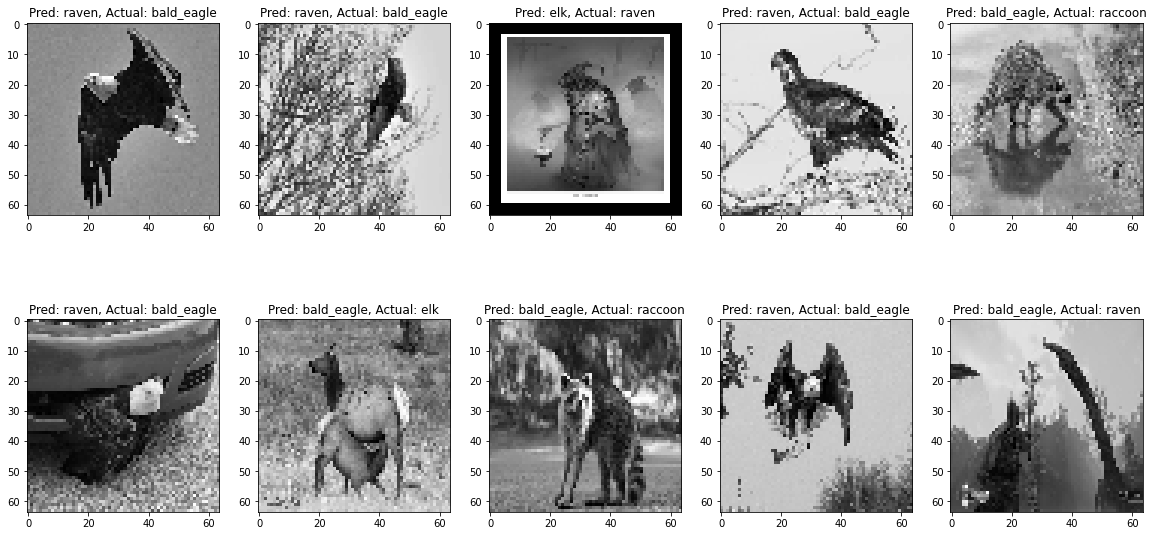

In [75]:
test_cond = Y_test.argmax(axis=1) == test_pred
classes_dict = dict(zip(train_ds.class_indices.values(), train_ds.class_indices.keys()))
print('Some Wrong predictions: ')
count = 0
plt.figure(figsize=(20,10))
for i in range(len(test_cond)):
  if test_cond[i] == True:
    continue
  plt.subplot(2,5,count+1)
  plt.imshow(X_test[i][..., 0], cmap='gray')
  plt.title(f'Pred: {classes_dict[test_pred[i]]}, Actual: {classes_dict[Y_test.argmax(axis=1)[i]]}')
  count += 1
  if count>=10:
    break
plt.show()


# Conclusion
We built and trained a number of models with different hyperparameters using the Keras functional API for our task of image classification. We examined the effects of different optimizers, epoch numbers, loss functions, and regularization techniques, and reached an accuracy of over 0.73 on the test set.